### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

Домашнее задание
1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [43]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']


continuos_transformers = []
cat_transformers = []

for cont_col in continuous_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', MinMaxScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=categorical_columns))
            ])
    cat_transformers.append((cat_col, cat_transformer))

In [10]:
feats = FeatureUnion(continuos_transformers+cat_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[0.458     , 0.31343284, 0.49429299, ..., 0.        , 1.        ,
        0.        ],
       [0.8       , 0.20895522, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.758     , 0.23880597, 0.22358532, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.776     , 0.25373134, 0.67652041, ..., 1.        , 1.        ,
        0.        ],
       [0.48      , 0.29850746, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.546     , 0.44776119, 0.45336397, ..., 1.        , 1.        ,
        0.        ]])

In [11]:
models_list = {"LogisticReg": LogisticRegression(C = 0.10,random_state = 42), 
               "RandomForest": RandomForestClassifier(random_state = 42), 
               "GradientBoosting": GradientBoostingClassifier(random_state = 42)
               }

classifiers_list = []
y_score_dict = {}

for key, value in models_list.items():
    classifier = Pipeline([
        ('features',feats),
        ('classifier', value),
    ])
    classifiers_list.append(classifier)
    
    #обучим наш пайплайн
    classifier.fit(X_train, y_train)

    y_score_dict[key] = classifier.predict_proba(X_test)[:, 1]

In [12]:
def calc_metrics(y_test, preds):

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    roc_auc = roc_auc_score(y_test, preds)
    
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [13]:
metrics = []

for key, value in y_score_dict.items():
    threshold, fscore, precision, recall, roc_auc = calc_metrics(y_test, value)
    
    metrics.append([threshold, fscore, precision, recall, roc_auc])

In [14]:
metrics_df = pd.DataFrame(metrics,
                          columns = ['threshold', 'f-score', 'precision', 'recall', 'roc_auc'],
                          index = y_score_dict.keys())
metrics_df

,threshold,f-score,precision,recall,roc_auc
LogisticReg,0.287248,0.498650,0.460133,0.544204,0.764507
RandomForest,0.340000,0.638655,0.608541,0.671906,0.863132
GradientBoosting,0.408508,0.646121,0.703704,0.597250,0.875760


Градиентный бустинг дает лучшие результаты

Думаю, здесь наиболее важен RECALL, так как нам важно максимально охватить людей
и здесь ответ на вопрос - что будет, если recall =1 получим низкую точность precision

Отрисуем матрицу ошибок

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


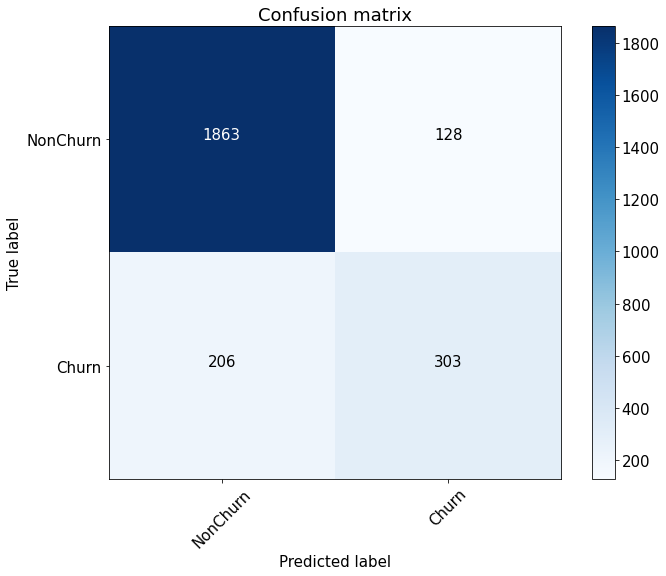

In [18]:
# возьмем порог fscore из градиентного бустинга 0.408508
font = {'size' : 15}

plt.rc('font', **font)

#cnf_matrix = confusion_matrix(y_test, y_score_dict['GradientBoosting']>opt_treshold*business_threshold)

cnf_matrix = confusion_matrix(y_test, y_score_dict['GradientBoosting']>0.408508)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [19]:
#Посчитаем FPR, TPR
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

In [104]:
#Посчитаем нужные нам метрики

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.5952848722986247, 0.06428930185836264, 0.9357106981416373)

Исходные данные:
    
1 доллар на привлечение, 
2 доллара - с каждого правильно классифицированного (True Positive) удержанного)

FP лишние траты на привлечение = cnf_matrix[0][1] 
FN пропустили, люди ушли = cnf_matrix[1][0] ничего не потратили на них
TN не собирались уходить, ничего не потратили на них
TP правильно определили отток, потратились на привлечение = cnf_matrix[1][1] но получили доход
Оценим расходы и доходы:

In [20]:
dollar_to_attract = 1
dollar_for_right_choice = 2

In [21]:
dollar_ML = TP * dollar_for_right_choice - (FP+TP) * dollar_to_attract
print('с использованием модели', dollar_ML)

с использованием модели 175


In [22]:
#Подберем перебором оптимальный порог

def business_threshold_calibrate(y_test, y_score, dollar_to_attract = 1, dollar_for_right_choice = 2):
    
    business_threshold = 0
    
    border = 0
    
    n = 30
    
    for opt_buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > ( opt_buisness_tr))
        
        dollar_ML = cnf_matrix[1][1] * dollar_for_right_choice - (cnf_matrix[0][1]+cnf_matrix[1][1]) * dollar_to_attract
       
        #print(dollar_ML)
        if (dollar_ML > border):
            
            business_threshold = opt_buisness_tr
            
            border = dollar_ML
        #print(border)
        #print("______")
        #print(business_threshold)
    
    print('доходы от модели', border)
    print('уровень порога по бизнес метрике',business_threshold)
    

In [23]:
Business_tr = business_threshold_calibrate(y_test, y_score_dict['GradientBoosting'], 
                                          dollar_to_attract = 1, dollar_for_right_choice = 2)

доходы от модели 187
уровень порога по бизнес метрике 0.5517241379310345


Задание 4

In [24]:
params = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__min_samples_leaf': [1, 5, 8],
    'classifier__max_depth': [3, 4, 5]
}

In [36]:
best_model = classifiers_list[2]
grid = GridSearchCV(best_model,
                    param_grid=params,
                    cv=5,
                    refit=False)

In [37]:
search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 2,
 'classifier__n_estimators': 300}

In [38]:
best_model_gs = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(n_estimators=300, max_depth=3, min_samples_leaf=2, random_state=42)),
])

In [39]:
best_model_gs.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age')),
                                                                 ('standard',
                                                                  MinMaxScaler())])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                 

In [40]:
y_pred_gs = best_model_gs.predict_proba(X_test)[:, 1]

In [41]:
Business_tr_2 = business_threshold_calibrate(y_test, y_pred_gs, 
                                          dollar_to_attract = 1, dollar_for_right_choice = 2)

доходы от модели 183
уровень порога по бизнес метрике 0.6551724137931034


In [ ]:
без подбора параметров модель отработала лучше

In [45]:
random1=RandomizedSearchCV(best_model, param_distributions=params, random_state=42)

In [46]:
search_random = random1.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 2,
 'classifier__n_estimators': 300}

In [ ]:
#RandomizedSearchCV и GridSearchCV дали одинаковый результат